In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import sqlite3
import json
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression

import os
from dotenv import load_dotenv
from utils.get_or_create_combined_database import get_or_create_combined_database
from utils.get_data import fetch_data_batches
from utils.create_sequences_in_batches import create_sequences_from_database_rows
load_dotenv(verbose=True, override=True)


from constants import DB_columns

database_folder = os.getenv("DATABASE_FOLDER")

database_file = get_or_create_combined_database(database_folder)

table_name = "champs_cleaned"

conn = sqlite3.connect(database_file)
query = 'SELECT * FROM champs_cleaned LIMIT 5'
data = pd.read_sql_query(query, conn)
conn.close()

# Display the first few rows of the dataframe
data.head()

Thumbs.db
combined2.db
Found 2 database files in the folder specified by DATABASE_FOLDER
Found combined database /u/23/tarpill1/unix/Documents/combined2.db


,game_id,time,name,hp,max_hp,mana,max_mana,armor,mr,ad,...,normalized_e_name,normalized_e_cd,normalized_r_name,normalized_r_cd,normalized_d_name,normalized_d_cd,normalized_f_name,normalized_f_cd,compound_key,role
0,2841236401,5.541945,Mordekaiser,645.0,645.0,0.0,100.0,61.0,32.0,61.0,...,1,-0.009084,1,-0.009084,1,0.020916,1,0.020916,2841236401_100_Mordekaiser,Top
1,2841236401,5.541945,Viego,630.0,630.0,10000.0,10000.0,46.0,32.0,62.4,...,2,-0.009084,2,-0.009084,1,0.020916,2,0.020916,2841236401_100_Viego,Jungle
2,2841236401,5.541945,Riven,745.0,745.0,0.0,0.0,33.0,32.0,84.8,...,3,-0.009084,3,-0.009084,1,0.020916,3,0.020916,2841236401_100_Riven,Mid
3,2841236401,5.541945,Ezreal,600.0,600.0,375.0,375.0,36.0,30.0,67.4,...,4,-0.009084,4,-0.009084,1,0.020916,4,0.020916,2841236401_100_Ezreal,Bot
4,2841236401,5.541945,Leblanc,598.0,598.0,400.0,400.0,34.0,30.0,55.0,...,5,-0.009084,5,-0.009084,1,0.020916,1,0.020916,2841236401_100_Leblanc,Bot


In [42]:
data_features =  [ DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value ]

labels = [ DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value ]
H_values = [80]
T_values = [20]

training_and_validation_set_size = 800
testing_set_size = 200

max_H = max(H_values)
max_T = max(T_values)

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} device')

Using cpu device


In [44]:
# Models

def train_model(model, X_train, y_train, epochs=50, batch_size=64, learning_rate=0.001, cutoff_loss=None):
    device = model.device
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        pbar = tqdm(
            train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for X_batch, y_batch in pbar:
            optimizer.zero_grad()
            output = model(X_batch)
            # Only use the first two feature dimensions for loss calculation
            loss = criterion(output[:, :2], y_batch[:, :2])
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'Loss': loss.item()})
        current_loss = loss.item()
        if cutoff_loss is not None and current_loss < cutoff_loss:
            print(
                f'Loss is below cutoff value of {cutoff_loss}. Stopping training.')
            break
        pbar.close()


# Function to predict with the PyTorch model


def predict_model(model, X, batch_size=64, no_progress=True):
    device = model.device
    model.to(device)
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    dataset = torch.utils.data.TensorDataset(X_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    predictions = []
    pbar = tqdm(loader, desc='Predicting') if not no_progress else loader
    with torch.no_grad():
        for X_batch, in pbar:
            output = model(X_batch)
            predictions.append(output.cpu().numpy())
    return np.vstack(predictions)


class TrajectoryPredictor(nn.Module):
    def __init__(self, input_shape, output_shape, lstm_units=128, device='cpu', parameters=None):
        super(TrajectoryPredictor, self).__init__()
        if parameters is not None:
            self.epochs = parameters['epochs']
            self.batch_size = parameters['batch_size']
            self.learning_rate = parameters['learning_rate']
            self.dropout_rate = parameters['dropout_rate']
        else:
            self.epochs = 10
            self.batch_size = 640
            self.learning_rate = 0.001
            self.dropout_rate = 0.2

        self.lstm1 = nn.LSTM(input_shape[-1], lstm_units, batch_first=True)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units, batch_first=True)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.fc = nn.Linear(lstm_units, output_shape)
        self.device = device

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.fc(x[:, -1, :])  # taking the output of the last time step
        return x

    def fit(self, X, y, cutoff_loss=None):
        train_model(self, X, y, self.epochs,
                    self.batch_size, self.learning_rate, cutoff_loss)

    def predict(self, X):
        return predict_model(self, X, self.batch_size)

In [45]:
linear_regression_features = [
    DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]

lstm_parameters = {'epochs': 10, 'batch_size': 256,
                'learning_rate': 0.0005}
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [64, 128, 256]
dropout_rates = [0.2, 0.4, 0.6]

lstm_parameter_sets = [
    {'epochs': 10,
        'batch_size': bs,
        'learning_rate': lr,
        'dropout_rate': dr
    } for bs in batch_sizes for lr in learning_rates for dr in dropout_rates
]

def get_lstm_name(params):
    return f"lstm_lr_{params['learning_rate']}_bs_{params['batch_size']}_dr_{params['dropout_rate']}"

lstm_models = [ (get_lstm_name(params), data_features, params) for params in lstm_parameter_sets ]
lstm_getters = dict(map(lambda x: (x[0], lambda H, T: (TrajectoryPredictor(
    input_shape=(H, len(x[1])),
    output_shape=2,
    device=device,
    parameters=x[2],
), x[1], (-1, H, len(x[1])))), lstm_models))

model_getters = {
    'linear_regression': lambda H, T: (LinearRegression(), linear_regression_features, (-1, H*len(linear_regression_features))),
    **lstm_getters
}

# Display model getters and their values in a table
pd.DataFrame({
    'Model': [ (key, H, T) for key in model_getters.keys() for H in H_values for T in T_values],
    'Features': [ len(x(H, T)[1]) for x in model_getters.values() for H in H_values for T in T_values],
    'Shape': [ x(H, T)[2] for x in model_getters.values() for H in H_values for T in T_values],
    'Parameters': [ x(H, T)[0].parameters if hasattr(x(H, T)[0], 'parameters') else None for x in model_getters.values() for H in H_values for T in T_values]
})

,Model,Features,Shape,Parameters
0,"(linear_regression, 80, 20)",2,"(-1, 160)",None
1,"(lstm_lr_0.0001_bs_64_dr_0.2, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...
2,"(lstm_lr_0.0001_bs_64_dr_0.4, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...
3,"(lstm_lr_0.0001_bs_64_dr_0.6, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...
4,"(lstm_lr_0.001_bs_64_dr_0.2, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...
5,"(lstm_lr_0.001_bs_64_dr_0.4, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...
6,"(lstm_lr_0.001_bs_64_dr_0.6, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...
7,"(lstm_lr_0.01_bs_64_dr_0.2, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...
8,"(lstm_lr_0.01_bs_64_dr_0.4, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...
9,"(lstm_lr_0.01_bs_64_dr_0.6, 80, 20)",2,"(-1, 80, 2)",<bound method Module.parameters of TrajectoryP...


In [46]:
# Load models
folder = 'models'
trained_models = {}
training_errors = {}
validation_errors = {}
test_errors = {}
model_names = model_getters.keys()
model_file_names = [ f'{H}_{T}_{model_name}.pt' for H in H_values for T in T_values for model_name in model_names]
for file_name in model_file_names:
    model_name_parts = file_name.split('.')
    model_name_parts = ".".join(model_name_parts[:-1]).split('_') if len(model_name_parts) > 2 else model_name_parts[0].split('_')
    model_name = (int(model_name_parts[0]), int(model_name_parts[1]), '_'.join(model_name_parts[2:]))
    trained_models[model_name] = torch.load(os.path.join(folder, file_name), map_location=torch.device(device))
    trained_models[model_name].device = device
    try:
        training_info_file_name = file_name.replace('.pt', '.json')
        with open(os.path.join(folder, training_info_file_name), 'r') as f:
            training_info = json.load(f)
        training_errors[model_name] = training_info['training_error']
        validation_errors[model_name] = training_info['validation_error']
        test_errors[model_name] = training_info['test_error']
        
    except FileNotFoundError:
        training_errors[model_name] = None
        validation_errors[model_name] = None
        print(f'Error loading training information for {training_info_file_name}')
    except Exception as e:
        print(f"Uncatched error: {e}")

# trained_models, training_errors, validation_errors
print("Models loaded")

/u/23/tarpill1/unix/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.4.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Models loaded


In [47]:
# Find the linear regression model name, and the best LSTM model name
linear_regression_model_name = [name for name in model_names if "linear_regression" in name][0]
print(test_errors.keys())
best_lstm_model_name = min([key for key in test_errors.keys() if linear_regression_model_name not in key], key=test_errors.get)[2]

models_to_visualize = list([ linear_regression_model_name, best_lstm_model_name])
models_to_visualize

dict_keys([(80, 20, 'linear_regression'), (80, 20, 'lstm_lr_0.0001_bs_64_dr_0.2'), (80, 20, 'lstm_lr_0.0001_bs_64_dr_0.4'), (80, 20, 'lstm_lr_0.0001_bs_64_dr_0.6'), (80, 20, 'lstm_lr_0.001_bs_64_dr_0.2'), (80, 20, 'lstm_lr_0.001_bs_64_dr_0.4'), (80, 20, 'lstm_lr_0.001_bs_64_dr_0.6'), (80, 20, 'lstm_lr_0.01_bs_64_dr_0.2'), (80, 20, 'lstm_lr_0.01_bs_64_dr_0.4'), (80, 20, 'lstm_lr_0.01_bs_64_dr_0.6'), (80, 20, 'lstm_lr_0.0001_bs_128_dr_0.2'), (80, 20, 'lstm_lr_0.0001_bs_128_dr_0.4'), (80, 20, 'lstm_lr_0.0001_bs_128_dr_0.6'), (80, 20, 'lstm_lr_0.001_bs_128_dr_0.2'), (80, 20, 'lstm_lr_0.001_bs_128_dr_0.4'), (80, 20, 'lstm_lr_0.001_bs_128_dr_0.6'), (80, 20, 'lstm_lr_0.01_bs_128_dr_0.2'), (80, 20, 'lstm_lr_0.01_bs_128_dr_0.4'), (80, 20, 'lstm_lr_0.01_bs_128_dr_0.6'), (80, 20, 'lstm_lr_0.0001_bs_256_dr_0.2'), (80, 20, 'lstm_lr_0.0001_bs_256_dr_0.4'), (80, 20, 'lstm_lr_0.0001_bs_256_dr_0.6'), (80, 20, 'lstm_lr_0.001_bs_256_dr_0.2'), (80, 20, 'lstm_lr_0.001_bs_256_dr_0.4'), (80, 20, 'lstm_lr_0.0

['linear_regression', 'lstm_lr_0.001_bs_128_dr_0.4']

In [48]:
# Fetch data

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

plotting_features = [DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value, DB_columns.NORMALIZED_NAME.value]
additional_features = [DB_columns.TIME.value, DB_columns.HP.value, DB_columns.NORMALIZED_NAME.value]

fetched_features = list(np.unique(data_features + plotting_features + additional_features))
fetched_features.sort(key=lambda feature: data_features.index(feature) if feature in data_features else len(data_features))

data = fetch_data_batches(cursor, table_name, "1=1", training_and_validation_set_size, testing_set_size, fetched_features)


Using in-memory cache for counts


Fetched 200 keys for offset: 800, limit: 200


In [49]:
predictions = {}
truths = {}

test_errors = {}

Predicting with model linear_regression


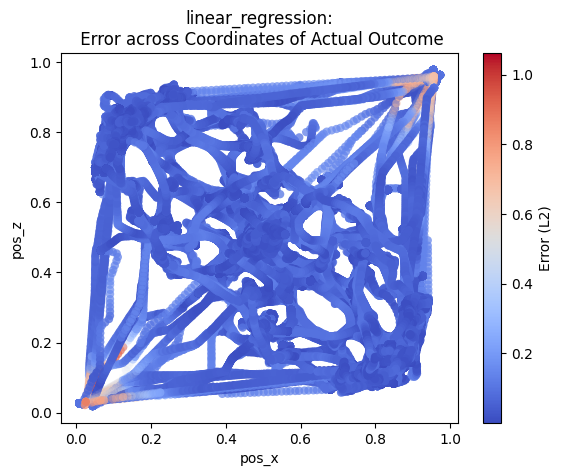

Predicting with model lstm_lr_0.001_bs_128_dr_0.4


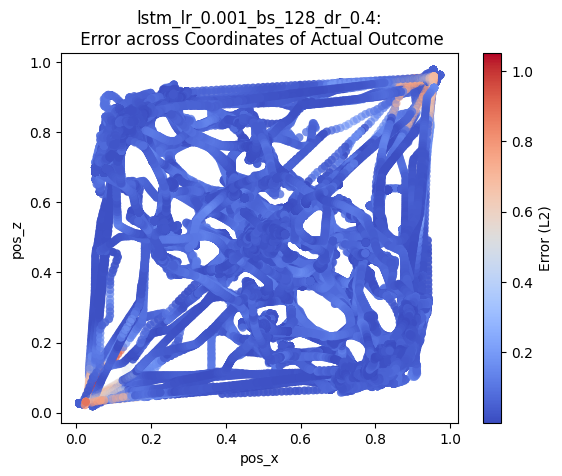

In [50]:
for (H, T, model_name), model in trained_models.items():
    if model_name not in models_to_visualize:
        continue
    input_shape = model_getters[model_name](H, T)[2]
    features = model_getters[model_name](H, T)[1]
    sequences = create_sequences_from_database_rows(data, H, T, max_H, max_T)
    X, y = sequences
    truths[model_name] = y  
    y_data_features = y[:, [labels.index(feature) for feature in features]]
    print(f"Predicting with model {model_name}")
    X_test_features = X[:, :, [
        data_features.index(feature) for feature in features]]
    X_test_features = X_test_features.reshape(
        X_test_features.shape[0], *input_shape)
    # Run the prediction on all the sequences
    y_pred = [ model.predict(X_test_features[i]) for i in range(X_test_features.shape[0]) ]
    y_pred = np.array(y_pred, dtype=np.float32).reshape(-1, len(labels))
    predictions[model_name] = y_pred
    # Visualize the best and worst predictions
    absolute_errors = np.linalg.norm(y_data_features - y_pred, axis=1)
    test_errors[model_name] = absolute_errors

    absolute_errors_normalized = absolute_errors / absolute_errors.max()
    absolute_errors_normalized = absolute_errors_normalized - 0.5
    absolute_errors_normalized = abs(absolute_errors_normalized) / abs(absolute_errors_normalized).max()
    plt.scatter(y_data_features[:, 0], y_data_features[:, 1], c=absolute_errors, cmap='coolwarm', edgecolors='black', linewidth=0, marker='o', alpha=absolute_errors_normalized)
    plt.colorbar( label='Error (L2)')
    plt.title(f'{model_name}:\n Error across Coordinates of Actual Outcome')
    plt.xlabel('pos_x')
    plt.ylabel('pos_z')
    plt.show()

